In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from tqdm import tqdm
from scipy.optimize import minimize

In [3]:
%config InlineBackend.figure_format = 'retina'
sns.set_style('darkgrid')

In [4]:
def calculate_metrics(cumret):
    '''
    calculate performance metrics from cumulative returns
    '''
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(52/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    rets.iloc[0] = 0
    sharpe = np.sqrt(52) * np.nanmean(rets) / np.nanstd(rets)
    
    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)
    
    return total_return, apr, sharpe, maxDD, maxDDD

# Volatility estimates

In [5]:
spy = yf.download('SPY', start='2018-01-01', end='2022-12-31')['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [6]:
spy_ret = spy.pct_change().dropna()

In [7]:
spy_hist_std = spy_ret.std()*np.sqrt(252) # annualized historical sd
spy_rolling_std = spy_ret.rolling(100).std().dropna()*np.sqrt(252) # annualized rolling sd (100 days)

In [8]:
spy_hist_std

0.21549739494630235

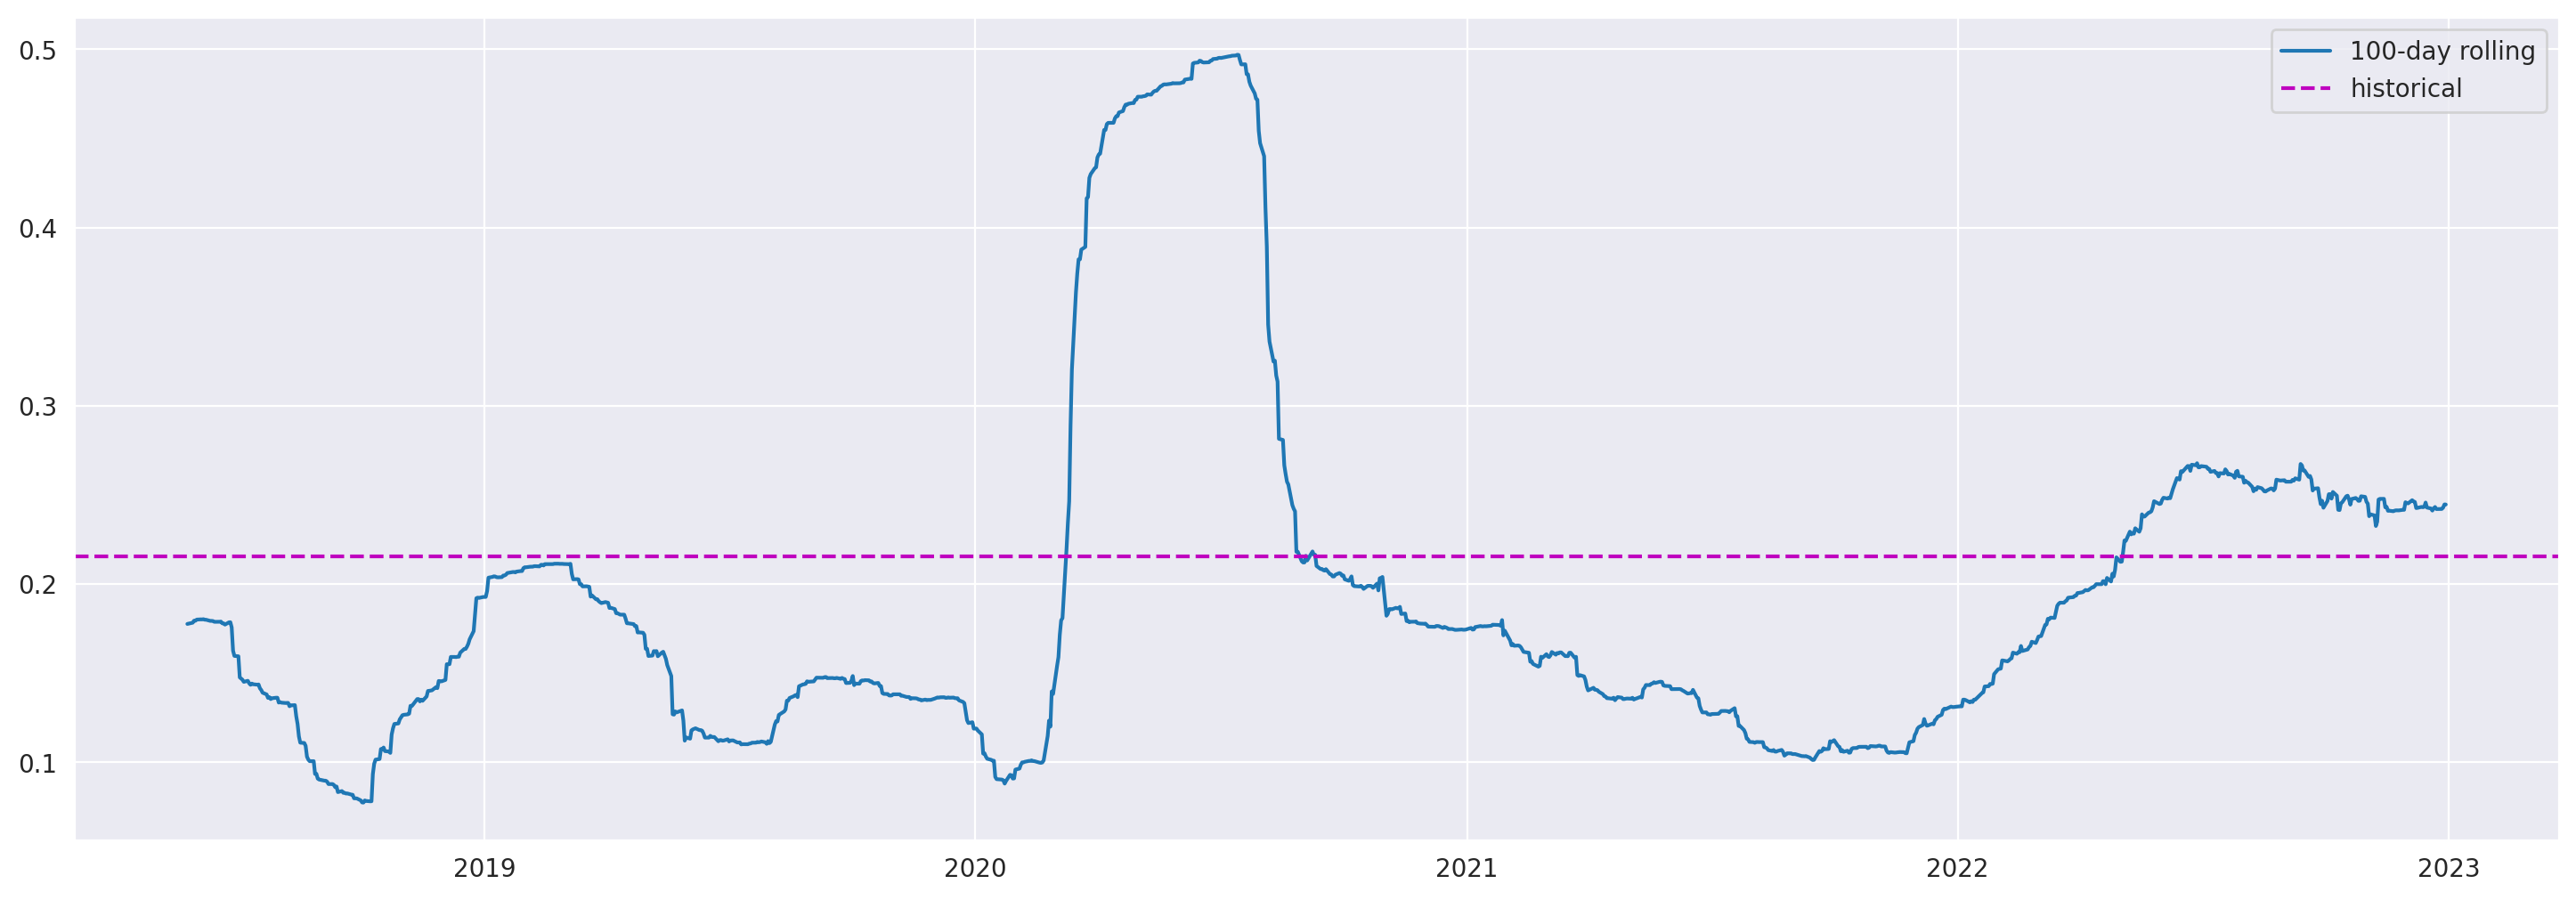

In [9]:
plt.figure(figsize=(18,6))
plt.plot(spy_rolling_std, label='100-day rolling')
plt.axhline(spy_hist_std, label='historical', color='m', linestyle='dashed')
plt.legend()

In [10]:
spy_rolling_std.describe()

count    1159.000000
mean        0.192142
std         0.098649
min         0.077386
25%         0.130970
50%         0.161983
75%         0.217246
max         0.496868
Name: Adj Close, dtype: float64

In [11]:
np.random.seed(1)
rs = spy_ret.mean() + spy_ret.std() * np.random.randn(len(spy_ret))
rs = pd.Series(rs, index=spy_ret.index)

In [12]:
rs_rolling_std = rs.rolling(100).std().dropna() * np.sqrt(252) # annualized rolling SD

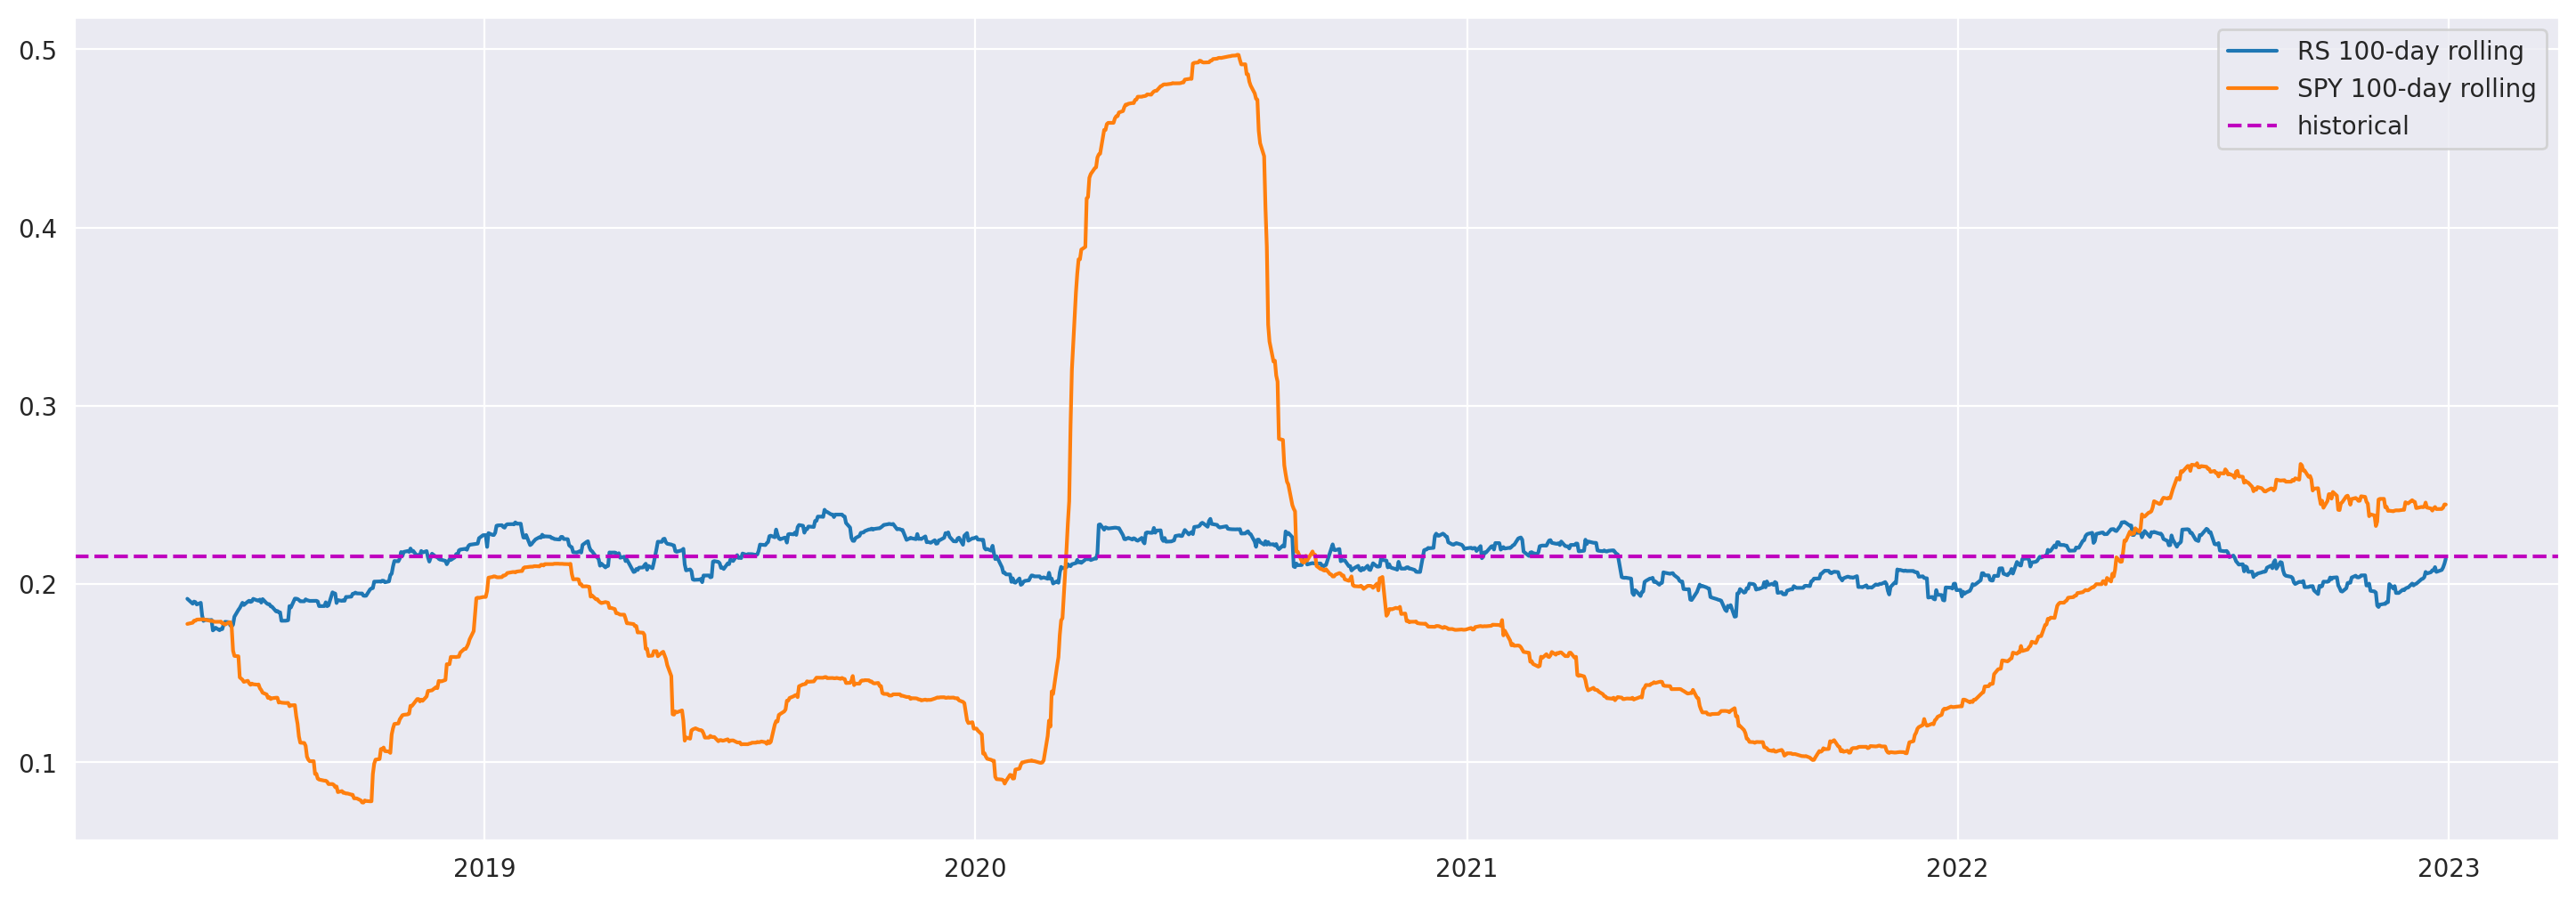

In [13]:
plt.figure(figsize=(18,6))
plt.plot(rs_rolling_std, label='RS 100-day rolling')
plt.plot(spy_rolling_std, label='SPY 100-day rolling')
plt.axhline(spy_hist_std, label='historical', color='m', linestyle='dashed')
plt.legend()

In [14]:
abs(spy_rolling_std - spy_hist_std).mean()

0.07907336527618358

In [15]:
abs(rs_rolling_std - spy_hist_std).mean()

0.011962551269402391

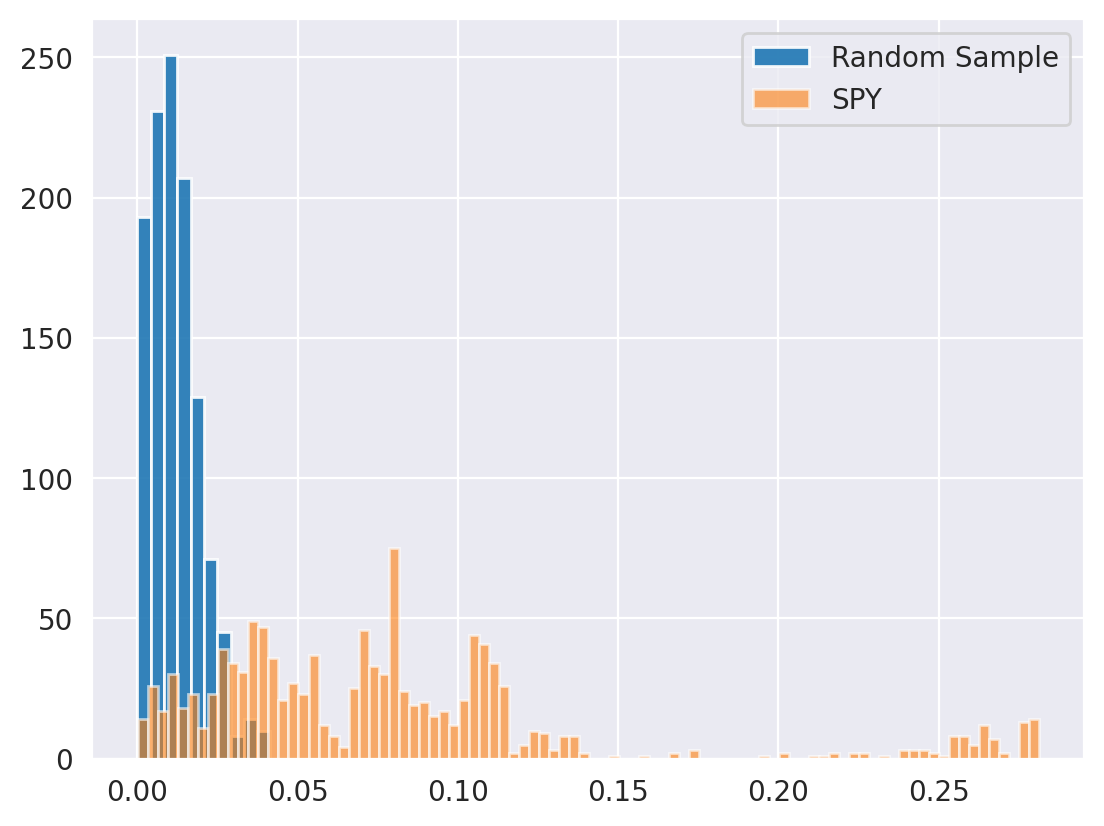

In [16]:
plt.hist(abs(rs_rolling_std - spy_hist_std), alpha=0.9, label='Random Sample')
plt.hist(abs(spy_rolling_std - spy_hist_std), alpha=0.6, bins=90, label='SPY')
plt.legend()

In [17]:
mean_std_diff = []

for i in range(10000):
    np.random.seed(i)
    rs = spy_ret.mean() + spy_ret.std() * np.random.randn(len(spy_ret))
    rs = pd.Series(rs)
    std_diff = rs.rolling(100).std().dropna() * np.sqrt(252) - spy_hist_std
    mean_std_diff.append(abs(std_diff).mean())

In [18]:
pd.Series(mean_std_diff).describe()

count    10000.000000
mean         0.012250
std          0.002118
min          0.005862
25%          0.010757
50%          0.012095
75%          0.013630
max          0.021767
dtype: float64

 # Correlation estimates

In [22]:
gld = yf.download('GLD', start='2018-01-01', end='2022-12-31')['Adj Close']
gld_ret = gld.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


In [23]:
np.corrcoef(spy_ret, gld_ret)

array([[1.        , 0.10551379],
       [0.10551379, 1.        ]])

In [24]:
hist_corr = np.corrcoef(spy_ret, gld_ret)[0,1]
hist_corr

0.10551379372120936

In [25]:
rolling_corr = spy_ret.rolling(100).corr(gld_ret).dropna()

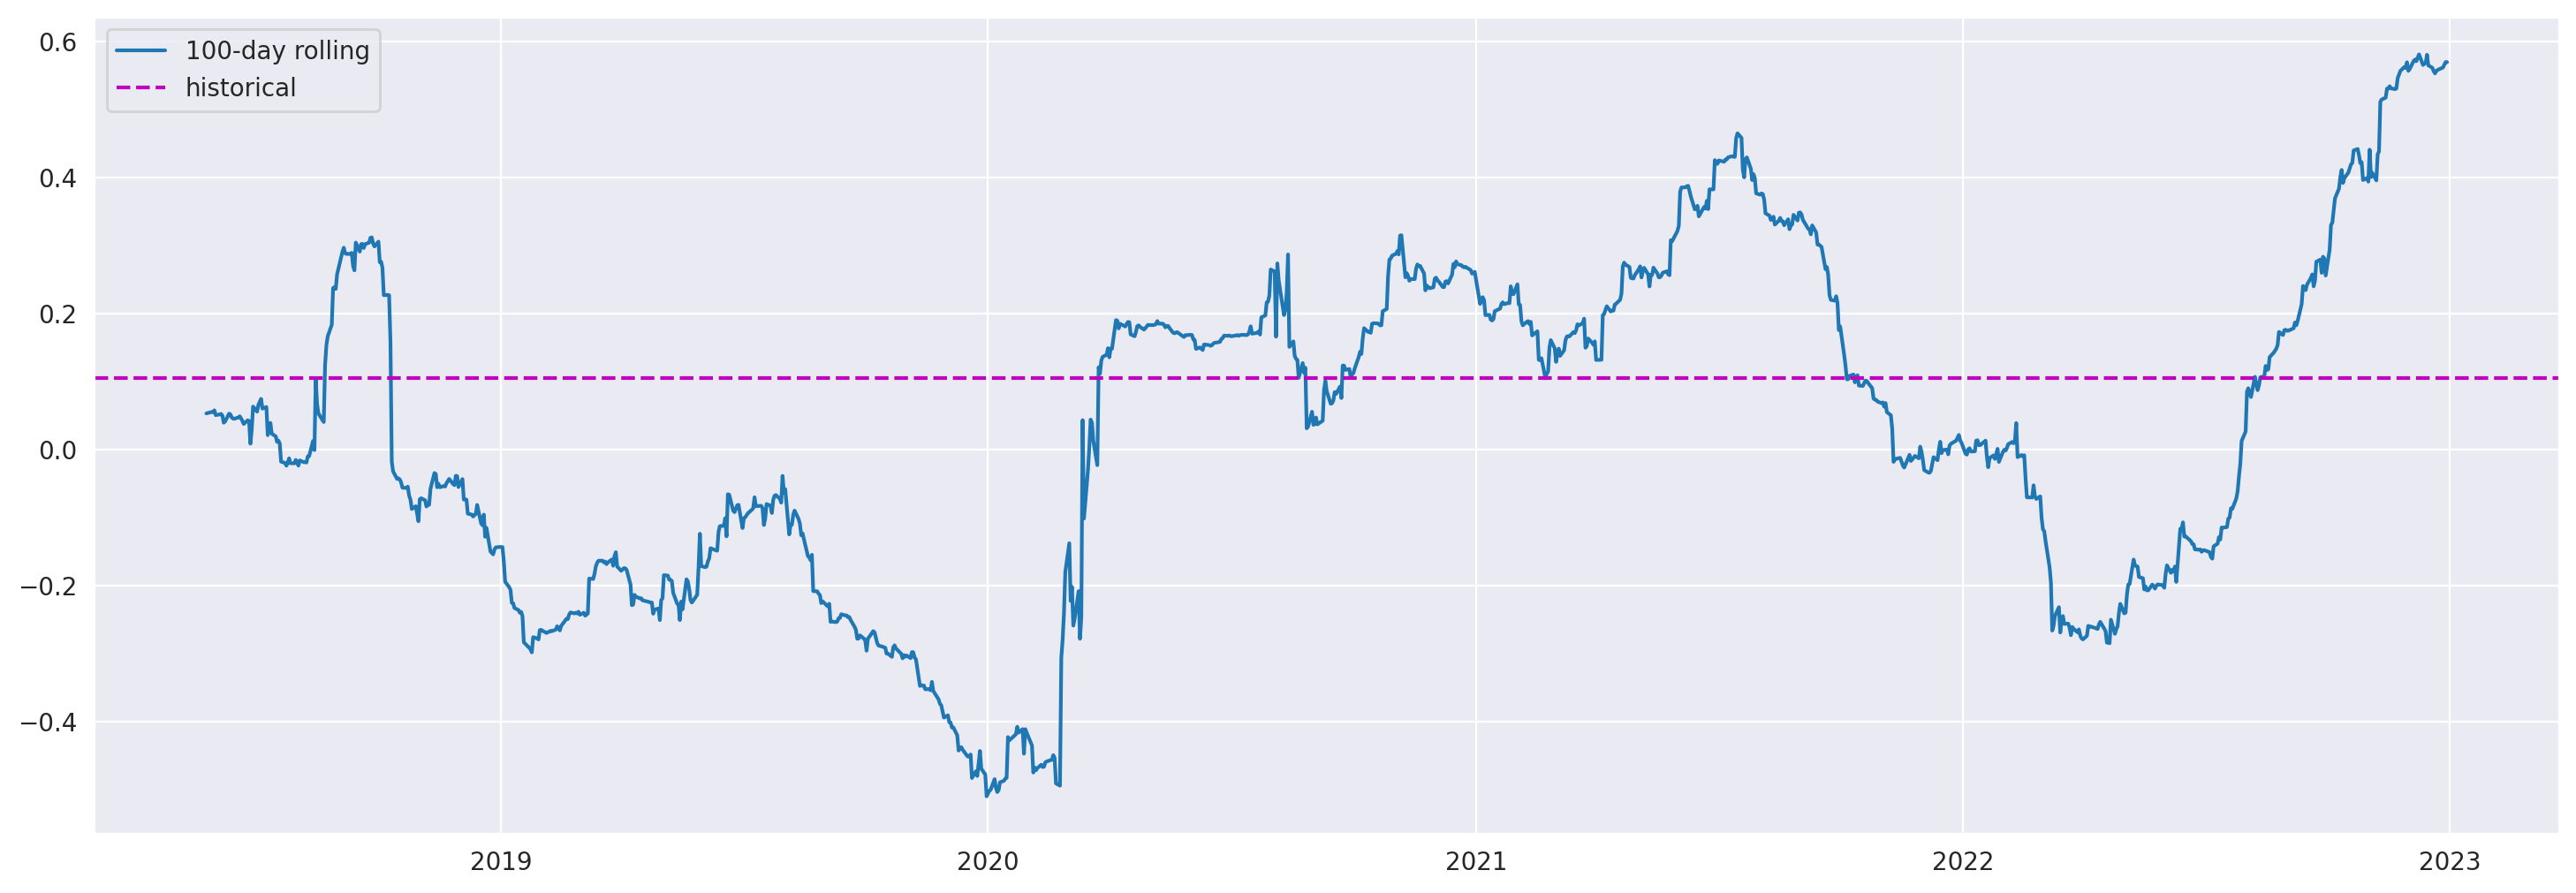

In [27]:
plt.figure(figsize=(18,6))
plt.plot(rolling_corr, label='100-day rolling')
plt.axhline(hist_corr, label='historical', color='m', linestyle='dashed')
plt.legend()

In [28]:
np.random.seed(1)
mu = np.array([spy_ret.mean(), gld_ret.mean()])
cov = np.cov(spy_ret, gld_ret)
rs = np.random.multivariate_normal(mean=mu, cov=cov, size=len(spy_ret))
rs = pd.DataFrame(rs, index=spy_ret.index)

In [29]:
rs_rolling_corr = rs[0].rolling(100).corr(rs[1]).dropna()

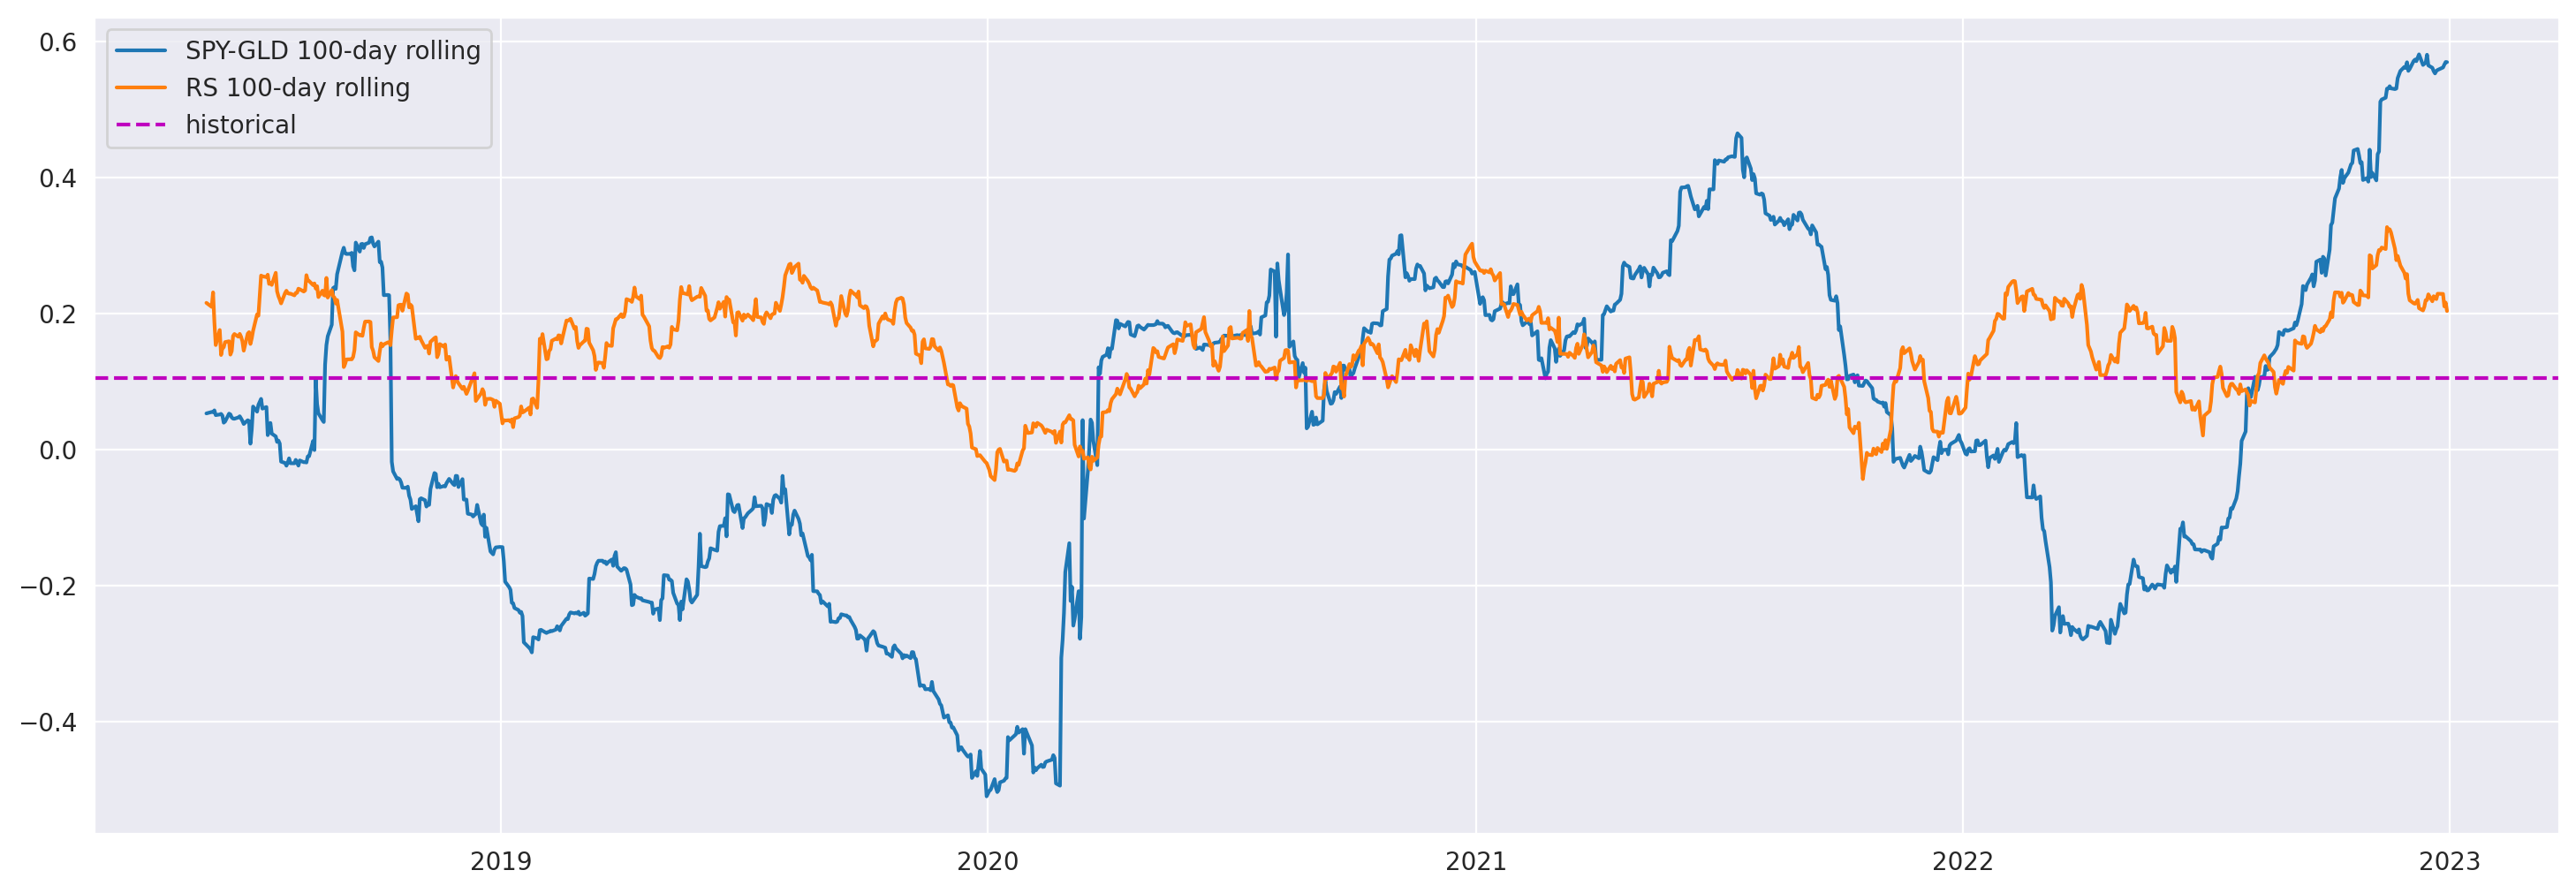

In [30]:
plt.figure(figsize=(18,6))
plt.plot(rolling_corr, label='SPY-GLD 100-day rolling')
plt.plot(rs_rolling_corr, label='RS 100-day rolling')
plt.axhline(hist_corr, label='historical', color='m', linestyle='dashed')
plt.legend()

In [31]:
abs(rolling_corr-hist_corr).mean()

0.2123518563525279

In [32]:
abs(rs_rolling_corr-hist_corr).mean()

0.06655984885170747

In [33]:
mean_corr_diff = []

mu = np.array([spy_ret.mean(), gld_ret.mean()])
cov = np.cov(spy_ret, gld_ret)

for _ in range(10000):
    rs = np.random.multivariate_normal(mean=mu, cov=cov, size=len(spy_ret))
    rs = pd.DataFrame(rs, index=spy_ret.index)
    rs_rolling_corr = rs[0].rolling(100).corr(rs[1]).dropna()
    corr_diff = rs_rolling_corr - hist_corr
    mean_corr_diff.append(abs(corr_diff).mean())

In [34]:
pd.Series(mean_corr_diff).describe()

count    10000.000000
mean         0.079510
std          0.013680
min          0.041728
25%          0.069762
50%          0.078584
75%          0.088297
max          0.135240
dtype: float64

# Fat tails

In [35]:
spy_ret_std = (spy_ret - spy_ret.mean()) / spy_ret.std()

In [36]:
len(spy_ret_std[abs(spy_ret_std)>2]) / len(spy_ret_std)

0.04531001589825119

In [37]:
gld_ret_std = (gld_ret - gld_ret.mean()) / gld_ret.std()

In [38]:
len(gld_ret_std[abs(gld_ret_std)>2]) / len(gld_ret_std)

0.05325914149443561

# Weighted estimators

In [39]:
d = 0.023 # decay rate

weighted_corr = pd.Series(index=spy_ret.iloc[252:].index)

for t in spy_ret.iloc[252:].index:
    # prepare data
    spy_tmp = spy_ret.loc[:t]
    gld_tmp = gld_ret.loc[:t]
    
    # construct weights
    weights = [1]
    for _ in range(len(spy_tmp)-1):
        w = weights[-1] * (1-d)
        weights.append(w)
        
    # calculate weighted covariance
    weighted_cov = np.cov(spy_tmp, gld_tmp, aweights=weights[::-1])
    
    # convert covariance to correlation
    D = np.sqrt(np.diag(np.diag(weighted_cov)))
    corr = (np.linalg.inv(D) @ weighted_cov @ np.linalg.inv(D))
    weighted_corr.loc[t] = corr[0,1]

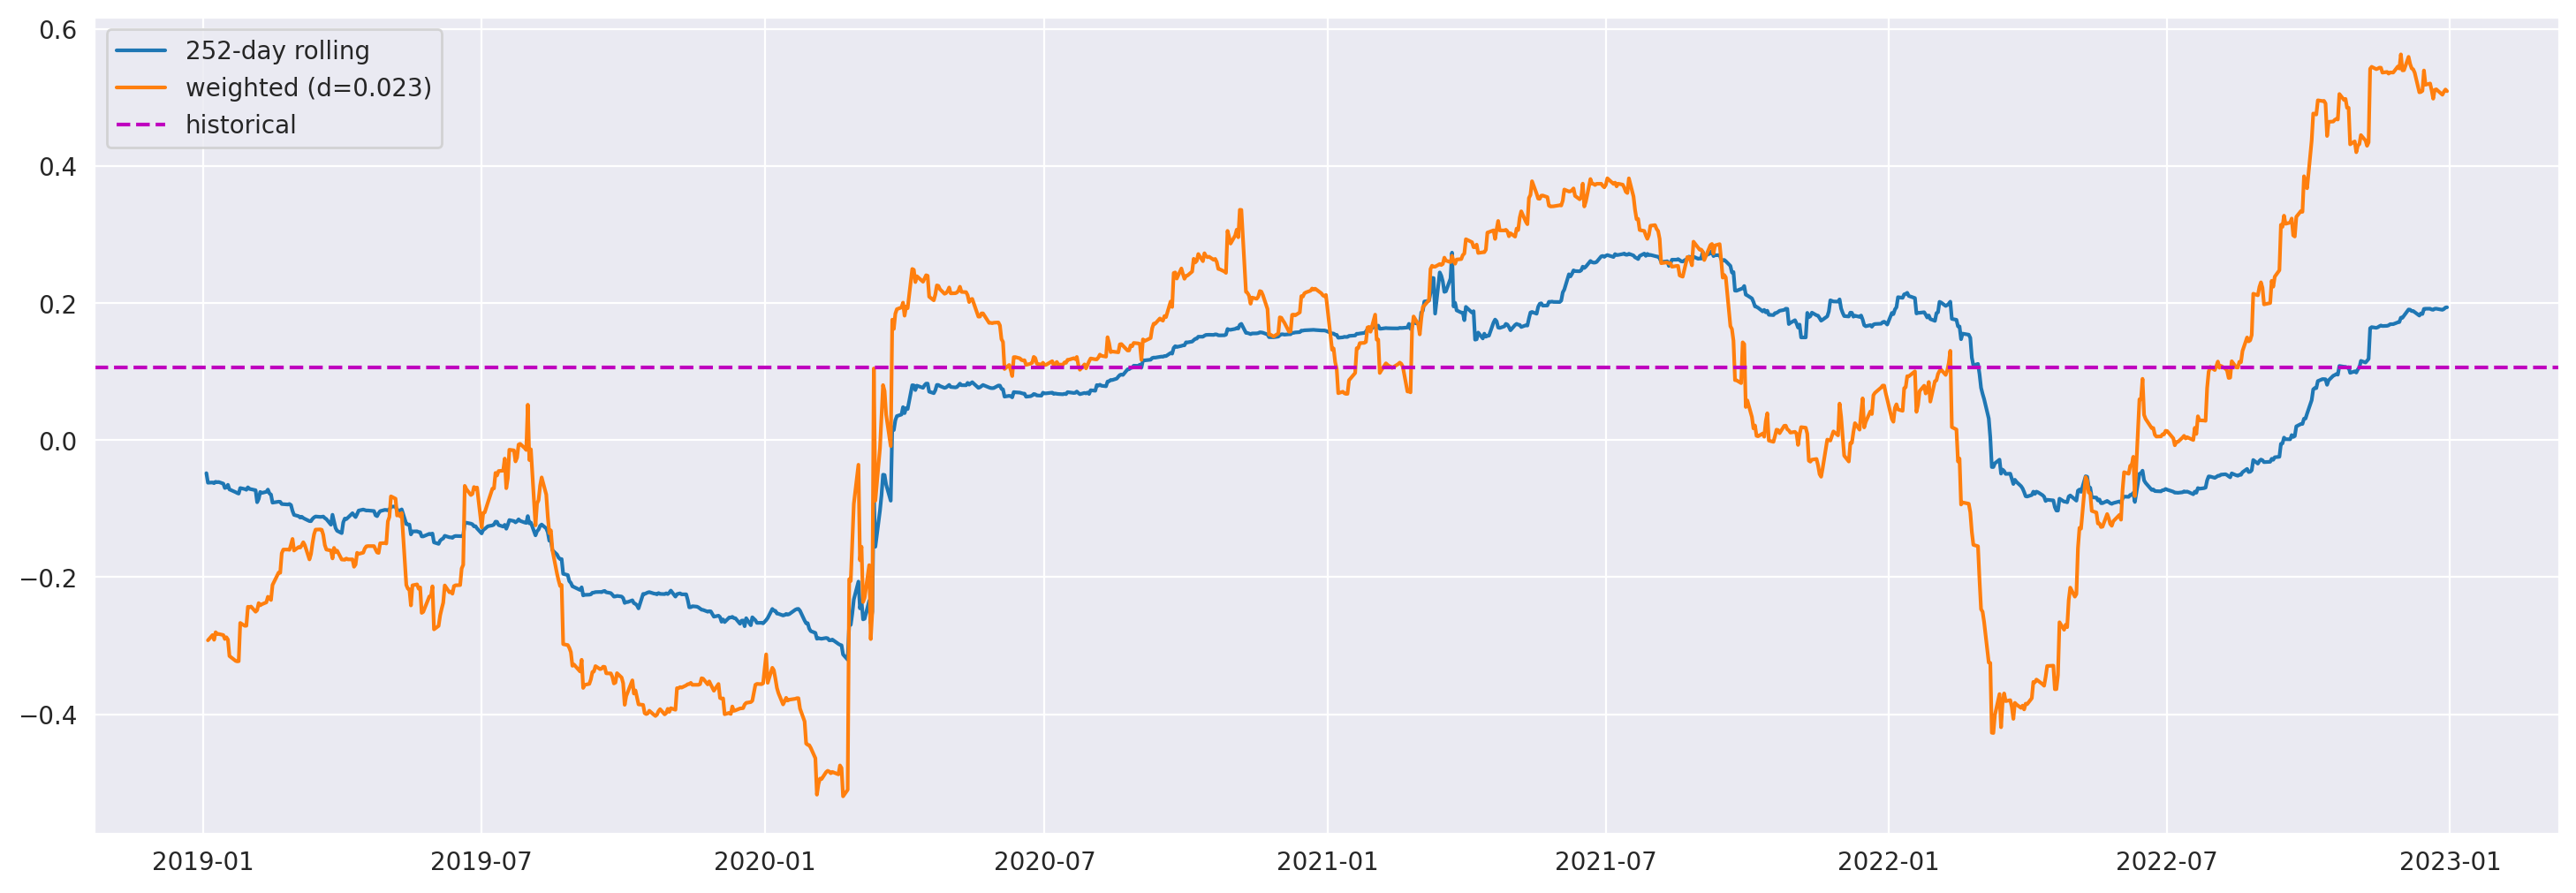

In [40]:
plt.figure(figsize=(18,6))
plt.plot(spy_ret.rolling(252).corr(gld_ret), label='252-day rolling')
plt.plot(weighted_corr, label=f'weighted (d={d})')
plt.axhline(hist_corr, label='historical', color='m', linestyle='dashed')
plt.legend()

# Download data

In [41]:
stocks = ['SPY', 'VWO', 'BNDX', 'USO', 'GLD']

In [42]:
tmpdf = yf.download(stocks[0], start='2018-01-01', end='2022-12-31')
prices = pd.DataFrame(index=tmpdf.index, columns=stocks)
prices[stocks[0]] = tmpdf['Adj Close']
for stock in stocks[1:]:
    tmpdf = yf.download(stock, start='2018-01-01', end='2022-12-31')
    prices[stock] = tmpdf['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [43]:
prices

,SPY,VWO,BNDX,USO,GLD
Date,,,,,
2018-01-02,243.072235,38.865032,45.769226,96.559998,125.150002
2018-01-03,244.609665,39.239532,45.802956,98.720001,124.820000
2018-01-04,245.640747,39.480877,45.811394,98.959999,125.459999
2018-01-05,247.277695,39.830406,45.811394,98.480003,125.330002
2018-01-08,247.729874,39.838734,45.819847,99.040001,125.309998
...,...,...,...,...,...
2022-12-23,377.177429,37.396240,45.661041,69.320000,167.259995
2022-12-27,375.690002,37.984936,45.488808,69.529999,168.669998
2022-12-28,371.020996,37.434845,45.469673,68.580002,167.910004


In [44]:
prices.isna().sum().sum()

0

In [45]:
returns = prices.pct_change().dropna()

In [46]:
# weekly prices and returns
prices_w = prices.resample('1W').last()
returns_w = prices_w.pct_change().dropna()

In [47]:
returns.cov()

,SPY,VWO,BNDX,USO,GLD
SPY,0.000184,0.000147,0.000006,0.000126,0.000013
VWO,0.000147,0.000196,0.000005,0.000127,0.000024
BNDX,0.000006,0.000005,0.000007,-0.000002,0.000008
USO,0.000126,0.000127,-0.000002,0.000772,0.000021
GLD,0.000013,0.000024,0.000008,0.000021,0.000082


In [48]:
returns.corr()

,SPY,VWO,BNDX,USO,GLD
SPY,1.000000,0.775705,0.167582,0.334543,0.105514
VWO,0.775705,1.000000,0.130378,0.327380,0.186708
BNDX,0.167582,0.130378,1.000000,-0.022749,0.312621
USO,0.334543,0.327380,-0.022749,1.000000,0.084250
GLD,0.105514,0.186708,0.312621,0.084250,1.000000


# Equally weighted portfolio

In [49]:
cumret_eqw = (1 + returns_w.loc['2019-01-01':].sum(axis=1)/returns_w.shape[1]).cumprod()
results_df = pd.DataFrame(columns=['Total return', 'APR', 'Sharpe', 'Max DD', 'Max DD Duration'])
results_df.loc['Equally Weighted'] = calculate_metrics(cumret_eqw)
results_df

,Total return,APR,Sharpe,Max DD,Max DD Duration
Equally Weighted,0.276915,0.062707,0.468062,-0.295495,66.0


In [50]:
volatility_eqw = cumret_eqw.pct_change().std() * np.sqrt(52)
volatility_eqw

0.1577562885788141

# Rolling window

In [51]:
def negative_annual_return(weights, returns):
    ret = weights.T @ returns.mean() * 252
    return -ret

def volatility(weights, returns):
    return np.sqrt(weights.T @ returns.cov() @ weights * 252)

In [52]:
positions = pd.DataFrame(index=prices_w.loc['2019-01-01':].index, 
                         columns=prices_w.columns)

In [53]:
target_vol = volatility_eqw
constraints = ({'type':'eq', 'fun': lambda x: volatility(x,returns_tmp)-target_vol}, 
               {'type':'eq', 'fun': lambda x: np.sum(x)-1})
bounds=[[0,1]]*len(stocks)
x0 = np.ones(len(stocks)) / len(stocks)

for t in tqdm(returns_w.loc['2019-01-01':].index):
    # prepare data
    prices_tmp = prices.loc[:t].iloc[-252:]
    returns_tmp = prices_tmp.pct_change().dropna()
    
    # perform optimization
    res = minimize(negative_annual_return, x0, args=(returns_tmp), 
               bounds=bounds, constraints=constraints)
    if res.status!=0:
        print('Optimization failed')
        positions.loc[t] = positions.loc[:t].iloc[-2] # keep previous weights
    else:
        positions.loc[t] = res.x

100%|██████████| 209/209 [00:16<00:00, 12.78it/s]


In [54]:
positions

,SPY,VWO,BNDX,USO,GLD
Date,,,,,
2019-01-06,0.903137,0.0,0.096863,0.0,0.0
2019-01-13,0.379569,0.0,0.223785,0.396646,0.0
2019-01-20,0.0,0.0,0.48494,0.51506,0.0
2019-01-27,0.0,0.0,0.484173,0.515827,0.0
2019-02-03,0.894327,0.0,0.105673,0.0,0.0
...,...,...,...,...,...
2022-12-04,0.001717,0.0,0.432076,0.313163,0.253044
2022-12-11,0.0,0.0,0.182563,0.221089,0.596348
2022-12-18,0.0,0.0,0.280443,0.259982,0.459575


In [55]:
cumret_rolling = (1 + (positions.shift() * returns_w.loc['2019-01-01':]).sum(axis=1)).cumprod()

In [56]:
results_df.loc['MPT (rolling window)'] = calculate_metrics(cumret_rolling)
results_df

,Total return,APR,Sharpe,Max DD,Max DD Duration
Equally Weighted,0.276915,0.062707,0.468062,-0.295495,66.0
MPT (rolling window),0.119957,0.028588,0.247493,-0.350829,129.0


In [57]:
cumret_rolling.pct_change().std() * np.sqrt(52)

0.18235486584177166

# Weighted mean and covariance

In [58]:
def volatility_weighted(weights, returns, d):
    
    # construct vector of weights for calculating covariance matrix
    w = [1]
    for i in range(len(returns)-1):
        w.append(w[-1]*(1-d))
    
    # calculate weighted covariance
    weighted_cov = np.cov(returns.T, aweights=w[::-1])
    
    return np.sqrt(weights.T @ weighted_cov @ weights * 252)

In [59]:
def negative_annual_return_weighted(weights, returns, d):
    
    # construct vector of weights for calculating weighted average
    w = [1]
    for i in range(len(returns)-1):
        w.append(w[-1]*(1-d))
        
    # calculate weighted average
    weighted_mean = np.average(returns.T, weights=w[::-1], axis=1)
    
    ret = weights.T @ weighted_mean * 252
    return -ret

In [60]:
positions = pd.DataFrame(index=prices_w.loc['2019-01-01':].index, 
                         columns=prices_w.columns)

In [61]:
target_vol = volatility_eqw
d = 0.023 # decay rate
constraints = ({'type':'eq', 'fun': lambda x: volatility_weighted(x,returns_tmp,d)-target_vol}, 
               {'type':'eq', 'fun': lambda x: np.sum(x)-1})
bounds=[[0,1]]*len(stocks)
x0 = np.ones(len(stocks)) / len(stocks)

for t in tqdm(returns_w.loc['2019-01-01':].index):
    prices_tmp = prices.loc[:t]
    returns_tmp = prices_tmp.pct_change().dropna()
    
    res = minimize(negative_annual_return_weighted, x0, args=(returns_tmp, d), 
               bounds=bounds, constraints=constraints)
    
    if res.status!=0:
        print('Optimization failed')
        positions.loc[t] = positions.loc[:t].iloc[-2] # keep previous weights
    else:
        positions.loc[t] = res.x

100%|██████████| 209/209 [00:14<00:00, 14.05it/s]


In [62]:
positions

,SPY,VWO,BNDX,USO,GLD
Date,,,,,
2019-01-06,0.0,0.692923,0.0,0.0,0.307077
2019-01-13,0.0,0.722261,0.0,0.0,0.277739
2019-01-20,0.0,0.75986,0.0,0.0,0.24014
2019-01-27,0.0,0.76587,0.0,0.0,0.23413
2019-02-03,0.0,0.777794,0.0,0.0,0.222206
...,...,...,...,...,...
2022-12-04,0.054963,0.254076,0.075819,0.0,0.615143
2022-12-11,0.0,0.090536,0.022385,0.0,0.887079
2022-12-18,0.0,0.0,0.061874,0.0,0.938126


In [63]:
cumret_weighted = (1 + (positions.shift() * returns_w.loc['2019-01-01':]).sum(axis=1)).cumprod()

In [64]:
results_df.loc['MPT (weighted)'] = calculate_metrics(cumret_weighted)
results_df

,Total return,APR,Sharpe,Max DD,Max DD Duration
Equally Weighted,0.276915,0.062707,0.468062,-0.295495,66.0
MPT (rolling window),0.119957,0.028588,0.247493,-0.350829,129.0
MPT (weighted),0.359929,0.079492,0.538023,-0.270869,91.0


In [65]:
cumret_weighted.pct_change().std() * np.sqrt(52)

0.16962847323820626

# Optimize for maximum Sharpe ratio (rolling window)

In [66]:
def negative_sharpe(weights, returns):
    ret = weights.T @ returns.mean() # mean daily returns
    std = np.sqrt(weights.T @ returns.cov() @ weights) # daily sd
    sharpe = np.sqrt(252) * ret / std
    return -sharpe

In [67]:
positions = pd.DataFrame(index=prices_w.loc['2019-01-01':].index, 
                         columns=prices_w.columns)

In [68]:
constraints = ({'type':'eq', 'fun': lambda x: np.sum(x)-1})
bounds=[[0,1]]*len(stocks)
x0 = np.ones(len(stocks)) / len(stocks)

for t in tqdm(returns_w.loc['2019-01-01':].index):
    # prepare data
    prices_tmp = prices.loc[:t].iloc[-252:]
    returns_tmp = prices_tmp.pct_change().dropna()
    
    # perform optimization
    res = minimize(negative_sharpe, x0, args=(returns_tmp), 
               bounds=bounds, constraints=constraints)
    if res.status!=0:
        print('Optimization failed')
        positions.loc[t] = positions.loc[:t].iloc[-2] # keep previous weights
    else:   
        positions.loc[t] = res.x

100%|██████████| 209/209 [00:15<00:00, 13.63it/s]


In [69]:
positions

,SPY,VWO,BNDX,USO,GLD
Date,,,,,
2019-01-06,0.001634,0.0,0.998366,0.0,0.0
2019-01-13,0.006023,0.0,0.993977,0.0,0.0
2019-01-20,0.010677,0.0,0.989323,0.0,0.0
2019-01-27,0.008338,0.0,0.991662,0.0,0.0
2019-02-03,0.015034,0.0,0.984966,0.0,0.0
...,...,...,...,...,...
2022-12-04,0.0,0.0,0.0,1.0,0.0
2022-12-11,0.0,0.0,0.0,1.0,0.0
2022-12-18,0.0,0.0,0.0,1.0,0.0


In [70]:
cumret_sharpe = (1 + (positions.shift() * returns_w.loc['2019-01-01':]).sum(axis=1)).cumprod()

In [71]:
cumret_sharpe

Date
2019-01-06           1
2019-01-13    0.998939
2019-01-20    1.002043
2019-01-27    1.006757
2019-02-03    1.009706
                ...   
2022-12-04    1.319649
2022-12-11    1.187571
2022-12-18    1.226307
2022-12-25    1.309824
2023-01-01    1.324751
Freq: W-SUN, Length: 209, dtype: object

In [72]:
results_df.loc['MPT Sharpe (rolling window)'] = calculate_metrics(cumret_sharpe)
results_df

,Total return,APR,Sharpe,Max DD,Max DD Duration
Equally Weighted,0.276915,0.062707,0.468062,-0.295495,66.0
MPT (rolling window),0.119957,0.028588,0.247493,-0.350829,129.0
MPT (weighted),0.359929,0.079492,0.538023,-0.270869,91.0
MPT Sharpe (rolling window),0.324751,0.072476,0.466405,-0.302674,61.0


In [73]:
cumret_sharpe.pct_change().std() * np.sqrt(52)

0.18863117083178718

# Optimize for maximum Sharpe ratio (weighted estimates)

In [74]:
def negative_sharpe_weighted(weights, returns, d):
    
    # construct vector of weights for weighted estimates
    w = [1]
    for i in range(len(returns)-1):
        w.append(w[-1]*(1-d))
    
    # weighted portfolio return
    weighted_mean = np.average(returns.T, weights=w[::-1], axis=1)
    ret = weights.T @ weighted_mean
    
    # weighted portfolio sd
    weighted_cov = np.cov(returns.T, aweights=w[::-1])
    std = np.sqrt(weights.T @ weighted_cov @ weights)
    
    sharpe = np.sqrt(252) * ret / std
    
    return -sharpe

In [75]:
positions = pd.DataFrame(index=prices_w.loc['2019-01-01':].index, 
                         columns=prices_w.columns)

In [76]:
constraints = ({'type':'eq', 'fun': lambda x: np.sum(x)-1})
bounds=[[0,1]]*len(stocks)
x0 = np.ones(len(stocks)) / len(stocks)
d = 0.023

for t in tqdm(returns_w.loc['2019-01-01':].index):
    # prepare data
    prices_tmp = prices.loc[:t]
    returns_tmp = prices_tmp.pct_change().dropna()
    
    # perform optimization
    res = minimize(negative_sharpe_weighted, x0, args=(returns_tmp, d), 
               bounds=bounds, constraints=constraints)
    if res.status!=0:
        print('Optimization failed')
        positions.loc[t] = positions.loc[:t].iloc[-2] # keep previous weights
    else:    
        positions.loc[t] = res.x

100%|██████████| 209/209 [00:15<00:00, 13.92it/s]


In [77]:
positions

,SPY,VWO,BNDX,USO,GLD
Date,,,,,
2019-01-06,0.0,0.010633,0.907184,0.0,0.082183
2019-01-13,0.0,0.026975,0.862785,0.0,0.11024
2019-01-20,0.014724,0.022653,0.904492,0.0,0.058131
2019-01-27,0.016528,0.02081,0.8864,0.0,0.076262
2019-02-03,0.033403,0.00368,0.863591,0.0,0.099325
...,...,...,...,...,...
2022-12-04,0.0,0.184017,0.495506,0.0,0.320477
2022-12-11,0.0,0.090986,0.0,0.0,0.909014
2022-12-18,0.0,0.0,0.0,0.0,1.0


In [78]:
cumret_sharpe_weighted = (1 + (positions.shift() * returns_w.loc['2019-01-01':]).sum(axis=1)).cumprod()

In [79]:
results_df.loc['MPT Sharpe (weighted)'] = calculate_metrics(cumret_sharpe_weighted)
results_df

,Total return,APR,Sharpe,Max DD,Max DD Duration
Equally Weighted,0.276915,0.062707,0.468062,-0.295495,66.0
MPT (rolling window),0.119957,0.028588,0.247493,-0.350829,129.0
MPT (weighted),0.359929,0.079492,0.538023,-0.270869,91.0
MPT Sharpe (rolling window),0.324751,0.072476,0.466405,-0.302674,61.0
MPT Sharpe (weighted),0.433127,0.093665,0.567611,-0.315059,53.0


In [80]:
cumret_sharpe_weighted.pct_change().std() * np.sqrt(52)

0.1903460220373162